📁 Using files:
 •      global: C:\Users\rusla\Desktop\Ruslan\AutDB-Video\data\Baseline\Experement - 4 (LODO)\metrics_lodo_intensity_global.csv
 • per_dataset: C:\Users\rusla\Desktop\Ruslan\AutDB-Video\data\Baseline\Experement - 4 (LODO)\metrics_lodo_intensity_per_dataset.csv
 •  train_only: C:\Users\rusla\Desktop\Ruslan\AutDB-Video\data\Baseline\Experement - 4 (LODO)\metrics_lodo_intensity_train_only.csv

✅ Rows: 12
📊 Metrics detected: ['auroc', 'f1', 'accuracy']
🔎 Primary metric: AUROC


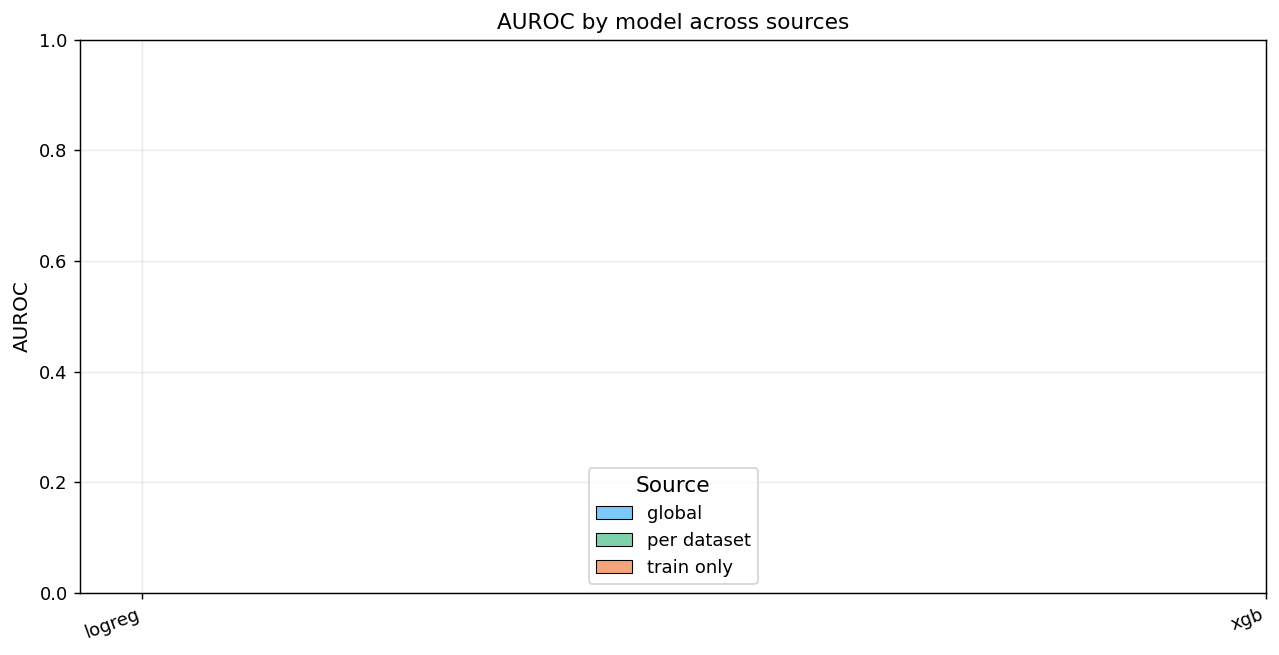

💾 Saved: C:\Users\rusla\Desktop\Ruslan\AutDB-Video\data\Baseline\Experement - 4 (LODO)\figures\bar_models_by_source_auroc.png
💾 Saved: C:\Users\rusla\Desktop\Ruslan\AutDB-Video\data\Baseline\Experement - 4 (LODO)\figures\bar_models_by_source_auroc.svg
ℹ️ Skipped dataset×model bars (need per_dataset with 'dataset' and 'model').


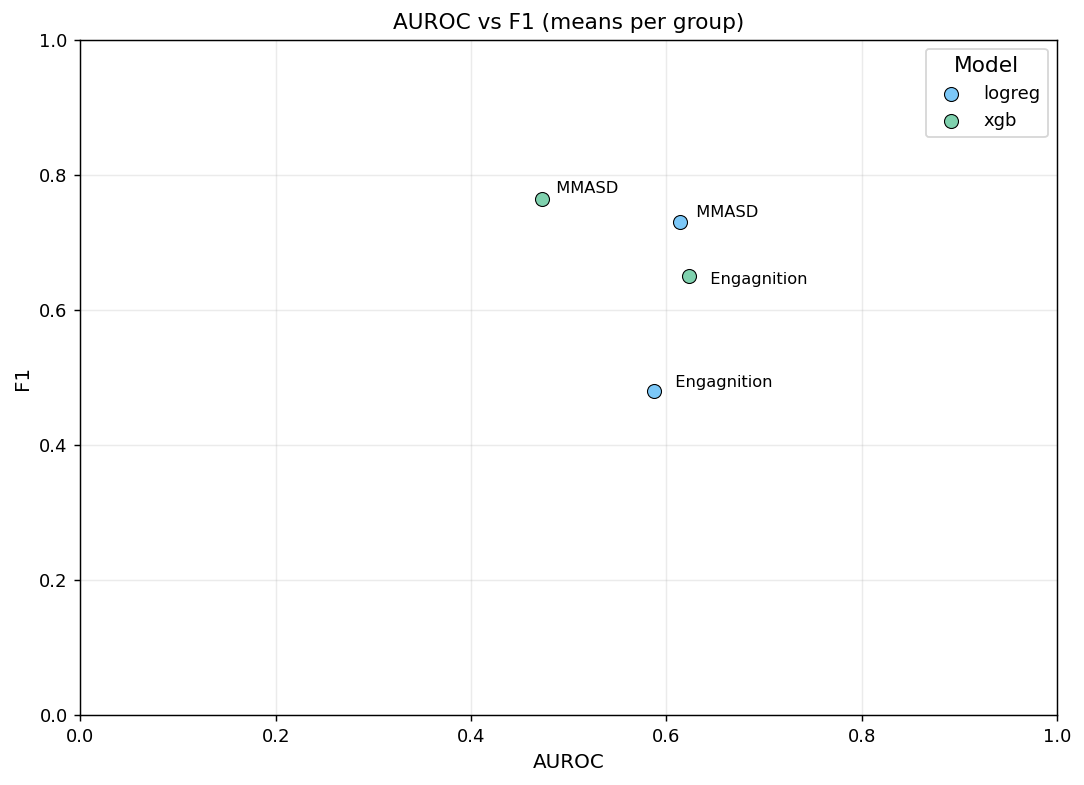

💾 Saved: C:\Users\rusla\Desktop\Ruslan\AutDB-Video\data\Baseline\Experement - 4 (LODO)\figures\scatter_auroc_vs_f1.png
💾 Saved: C:\Users\rusla\Desktop\Ruslan\AutDB-Video\data\Baseline\Experement - 4 (LODO)\figures\scatter_auroc_vs_f1.svg

✅ Done. Figures are in: C:\Users\rusla\Desktop\Ruslan\AutDB-Video\data\Baseline\Experement - 4 (LODO)\figures


In [8]:
# ============================
# Robust loader + clear plots (all three CSVs in the SAME folder)
# ============================
import os, re, math
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Optional: nicer text placement for scatter labels
try:
    from adjustText import adjust_text
except Exception:
    adjust_text = None

# ---------- Config ----------
BASE = Path(".").resolve()
FILES = {
    "global":      BASE / "metrics_lodo_intensity_global.csv",
    "per_dataset": BASE / "metrics_lodo_intensity_per_dataset.csv",
    "train_only":  BASE / "metrics_lodo_intensity_train_only.csv",
}

# Palette (your tones)
COLOR_BLUE   = "#7CC8F8"   # light blue
COLOR_GREEN  = "#7FD1AE"   # light green
COLOR_ORANGE = "#F6A57A"   # light orange
COLOR_GREY   = "#9AA2A9"

plt.rcParams.update({
    "figure.dpi": 130,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
})

# Column synonyms (case/space insensitive)
SYN = {
    "dataset":       ["dataset","data_set","source_dataset","ds","corpus"],
    "model":         ["model","estimator","clf","classifier","algorithm"],
    "scenario":      ["scenario","split","setting","mode","eval_scenario"],
    "normalization": ["normalization","scaler","scaling","preprocess","preprocessing","norm","standardization"],
    "target":        ["task","target","label_name","label"],
    # metrics
    "auroc":         ["auroc","roc_auc","roc-auc","auc"],
    "f1":            ["f1","f1_macro","macro_f1","f1-score","f1_pos","f1_macro_avg"],
    "bal_acc":       ["balanced_accuracy","balanced_acc","bal_acc","balacc","balanced-accuracy"],
    "accuracy":      ["accuracy","acc","accu"],
}

def norm(s: str) -> str:
    return re.sub(r"[^a-z0-9]+", "", s.lower())

def pick_col(df: pd.DataFrame, candidates: list[str]) -> str | None:
    if df is None or df.empty:
        return None
    nmap = {norm(c): c for c in df.columns}
    for cand in candidates:
        nc = norm(cand)
        if nc in nmap:
            return nmap[nc]
    # relaxed contains
    for c in df.columns:
        if any(norm(x) in norm(c) for x in candidates):
            return c
    return None

def coerce_num(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s, errors="coerce")

def infer_scenario_from_name(p: Path) -> str:
    n = p.name.lower()
    if "lodo" in n: return "LODO"
    if "iid"  in n: return "IID"
    return "unknown"

# ---------- Load strictly these three files ----------
missing = [k for k,p in FILES.items() if not p.exists()]
if missing:
    raise FileNotFoundError("Missing files:\n" + "\n".join(f"- {k}: {FILES[k]}" for k in missing))

print("📁 Using files:")
for k,p in FILES.items():
    print(f" • {k:>11}: {p}")

frames = []
for source, path in FILES.items():
    df = pd.read_csv(path)
    if df.empty:
        print(f"⚠️ Empty file skipped: {path}")
        continue

    c_model   = pick_col(df, SYN["model"])
    c_dataset = pick_col(df, SYN["dataset"])
    c_scen    = pick_col(df, SYN["scenario"])
    c_norm    = pick_col(df, SYN["normalization"])
    c_target  = pick_col(df, SYN["target"])

    c_auroc   = pick_col(df, SYN["auroc"])
    c_f1      = pick_col(df, SYN["f1"])
    c_bal     = pick_col(df, SYN["bal_acc"])
    c_acc     = pick_col(df, SYN["accuracy"])

    view = pd.DataFrame()
    view["__source__"] = source
    view["__file__"]   = str(path)

    view["model"]         = df[c_model]   if c_model   else "unknown"
    view["dataset"]       = df[c_dataset] if c_dataset else ("global" if source=="global" else "unknown")
    view["scenario"]      = df[c_scen]    if c_scen    else infer_scenario_from_name(path)
    view["normalization"] = df[c_norm]    if c_norm    else "none"
    if c_target: view["target"] = df[c_target]

    if c_auroc: view["auroc"]    = coerce_num(df[c_auroc])
    if c_f1:    view["f1"]       = coerce_num(df[c_f1])
    if c_bal:   view["bal_acc"]  = coerce_num(df[c_bal])
    if c_acc:   view["accuracy"] = coerce_num(df[c_acc])

    frames.append(view)

metrics = pd.concat(frames, ignore_index=True)
present_metrics = [m for m in ["auroc","f1","bal_acc","accuracy"] if m in metrics.columns and metrics[m].notna().any()]
print("\n✅ Rows:", len(metrics))
print("📊 Metrics detected:", present_metrics if present_metrics else "— none —")

# choose primary metric
priority = ["auroc","f1","bal_acc","accuracy"]
primary = next((m for m in priority if m in metrics.columns and metrics[m].notna().any()), None)
if primary is None:
    raise ValueError("No valid metric columns in the three CSVs.")
print("🔎 Primary metric:", primary.upper())

mx = metrics[metrics[primary].notna()].copy()

# ---------- Plots (saved to ./figures) ----------
FIG = BASE / "figures"
FIG.mkdir(exist_ok=True)

def bar_models_by_source(df: pd.DataFrame, metric: str, save_png: Path, save_svg: Path):
    """
    Grouped bars: metric by model across sources (global / per_dataset(avg) / train_only).
    Colors: blue/green/orange cycle per model for clarity.
    """
    # For per_dataset, average over datasets to be comparable with global/train_only
    agg = df.copy()
    # Bring to one row per source×model
    if not {"__source__","model"}.issubset(agg.columns):
        agg = agg.assign(model="model")
    grp = agg.groupby(["__source__","model"], dropna=False)[metric].mean().reset_index()

    # Keep consistent model order by overall mean
    order_models = grp.groupby("model")[metric].mean().sort_values(ascending=False).index.tolist()
    grp["model"] = pd.Categorical(grp["model"], categories=order_models, ordered=True)
    grp = grp.sort_values(["model","__source__"])

    sources = ["global","per_dataset","train_only"]
    x_labels = order_models
    x = np.arange(len(x_labels))

    width = 0.25
    fig, ax = plt.subplots(figsize=(10, 5.2))
    palettes = [COLOR_BLUE, COLOR_GREEN, COLOR_ORANGE]
    bars = []
    for i, src in enumerate(sources):
        sub = grp[grp["__source__"] == src]
        y = sub.set_index("model")[metric].reindex(order_models).values
        bars.append(ax.bar(x + (i-1)*width, y, width, label=src.replace("_"," "), 
                           color=palettes[i % len(palettes)], edgecolor="black", linewidth=0.6))
    ax.set_xticks(x)
    ax.set_xticklabels([str(m) for m in order_models], rotation=20, ha="right")
    ax.set_ylabel(metric.upper())
    ax.set_title(f"{metric.upper()} by model across sources")
    ax.set_ylim(0, 1 if metric in ["auroc","f1","bal_acc","accuracy"] else None)
    ax.legend(title="Source")
    plt.tight_layout()
    plt.savefig(save_png, bbox_inches="tight")
    plt.savefig(save_svg, bbox_inches="tight")
    plt.show()
    print(f"💾 Saved: {save_png}\n💾 Saved: {save_svg}")

def bar_by_dataset_per_model(df: pd.DataFrame, metric: str, save_png: Path, save_svg: Path):
    """
    For the per-dataset file only: bars by model within each dataset.
    """
    sub = df[df["__source__"] == "per_dataset"].copy()
    if sub.empty or not {"dataset","model"}.issubset(sub.columns):
        print("ℹ️ Skipped dataset×model bars (need per_dataset with 'dataset' and 'model').")
        return
    agg = sub.groupby(["dataset","model"], dropna=False)[metric].mean().reset_index()
    datasets = agg["dataset"].astype(str).unique().tolist()
    n = len(datasets)
    fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(10, 3.0*n), constrained_layout=True)
    if n == 1: axes = [axes]
    palette = [COLOR_BLUE, COLOR_GREEN, COLOR_ORANGE]
    for ax, ds in zip(axes, datasets):
        s = agg[agg["dataset"] == ds].copy()
        s = s.sort_values(metric, ascending=False)
        colors = [palette[i % len(palette)] for i in range(len(s))]
        ax.bar(s["model"].astype(str), s[metric], color=colors, edgecolor="black", linewidth=0.6)
        ax.set_title(f"{metric.upper()} — dataset: {ds}")
        ax.set_ylabel(metric.upper())
        ax.set_ylim(0, 1 if metric in ["auroc","f1","bal_acc","accuracy"] else None)
        ax.tick_params(axis="x", rotation=25)
    plt.savefig(save_png, bbox_inches="tight")
    plt.savefig(save_svg, bbox_inches="tight")
    plt.show()
    print(f"💾 Saved: {save_png}\n💾 Saved: {save_svg}")

def scatter_auroc_vs_f1(df_all: pd.DataFrame, save_png: Path, save_svg: Path):
    if not {"auroc","f1"}.issubset(df_all.columns):
        print("ℹ️ Scatter skipped (need both AUROC and F1).")
        return
    base = df_all.dropna(subset=["auroc","f1"]).copy()
    # one point per dataset×model×source if available; else per model×source
    group_fields = [c for c in ["dataset","model","__source__"] if c in base.columns]
    if not group_fields:
        group_fields = ["model"]
    agg = base.groupby(group_fields, dropna=False)[["auroc","f1"]].mean().reset_index()

    fig, ax = plt.subplots(figsize=(8.5, 6.2))
    models = agg["model"].astype(str).unique() if "model" in agg.columns else ["model"]
    model_colors = {m: [COLOR_BLUE, COLOR_GREEN, COLOR_ORANGE][i % 3] for i,m in enumerate(models)}

    for m, sub in agg.groupby("model" if "model" in agg.columns else None):
        ax.scatter(sub["auroc"], sub["f1"], s=60, edgecolors="black", linewidths=0.6,
                   label=str(m), c=model_colors.get(m, COLOR_GREY))
    ax.set_xlabel("AUROC"); ax.set_ylabel("F1")
    ax.set_xlim(0,1); ax.set_ylim(0,1)
    ax.legend(title="Model", frameon=True)

    # label by dataset (if available)
    texts = []
    label_field = "dataset" if "dataset" in agg.columns else "__source__" if "__source__" in agg.columns else None
    if label_field:
        for _, r in agg.iterrows():
            texts.append(ax.text(r["auroc"], r["f1"], "  " + str(r[label_field]), fontsize=9))
    if texts and adjust_text:
        adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-", lw=0.5, color=COLOR_GREY))
    ax.set_title("AUROC vs F1 (means per group)")
    plt.tight_layout()
    plt.savefig(save_png, bbox_inches="tight")
    plt.savefig(save_svg, bbox_inches="tight")
    plt.show()
    print(f"💾 Saved: {save_png}\n💾 Saved: {save_svg}")

# ---- Run all plots
FIG = BASE / "figures"
FIG.mkdir(exist_ok=True)

bar_models_by_source(mx, primary, FIG / f"bar_models_by_source_{primary}.png", FIG / f"bar_models_by_source_{primary}.svg")
bar_by_dataset_per_model(mx, primary, FIG / f"bar_by_dataset_{primary}.png", FIG / f"bar_by_dataset_{primary}.svg")
scatter_auroc_vs_f1(metrics, FIG / "scatter_auroc_vs_f1.png", FIG / "scatter_auroc_vs_f1.svg")

print("\n✅ Done. Figures are in:", FIG)
